In [11]:
import numpy as np #for numerical manipulations
import pandas as pd #for data processing like opening csv files
import os #to mention the directory where the dataset is stored
import matplotlib.pyplot as plt
import sys
import os
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as k
import keras

All the necessary libraries are imported. Numpy is for numerical manipulations. Pandas are for
dealing with csv files. MatplotLib is visualizing tool. keras is used here which is open source library
for neural networks in python. ImageDataGenerator is used for Data augumentation. Optimizers will
help us to find the global minima. Earlystopping is used to incase if we find that over a specific
number of epoch the accuracy is not improving then the training could be stopped.

In [12]:
from tensorflow import keras
base_model = keras.applications.VGG16(weights='imagenet',input_shape=(224,224,3),include_top=False)

VGG16 is the convolution neural network proposed in 2014. It is trained using imagenet dataset
which roughly has 15million high resolution images belonging to 22,000 categories. We are doing
Transfer Learning here. Using this model which was already trained with millions of data will help to
make prediction accurately by not only depending on the dataset we have.
We are giving include_top=False because VGG16 is a sequence of convolution layers with a dense
layer at the end. By giving it as false we mean that we are dropping the dense layer alone. Instead of
the dense layer which is already present we will model a full connected layer which will be
connected to VGG16.

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
base_model.trainable=False #freezing the model

Here we are freezing the base model which means that we are fixing the weights which are currently
used and we cannot modify the weights of the base model any further.

In [15]:
inputs = Input(shape=(224,224,3)) #input layer is creared
x = base_model(inputs, training=False) 
x = Flatten()(x) #Flattening Layer is added
x = Dense(256, activation='relu')(x) #Adding a Hidden Layer with 256 neuron
x = Dropout(0.5)(x) #adding a drop out layer
outputs = Dense(2, activation='softmax')(x) #creating the output layer which is basicallu Idle / Fall
model = Model(inputs,outputs) #creating the model

Here we are creating our own model on top of the base model. Input layer is of size 224,224,3
where 3 reprsents the RGB. A flatten layer is added which basically converts the 3d array of images
into a 1D vector. A hidden layer with 256 neurons are created with relu as the activation function.
With Deep Neural Network there are more chances that over fitting might occur considering the
very minimal image data that we are going to train. Hence to avoid overfitting droput layer is added
which randomly avoid certain neurons output so that balance is maintained. The output layer has 2
neurons which basically is 2 classifications of our research project currently - Idle and Fall. A model is created by linking the input and the output.

In [16]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
__________________________________

In [17]:
model.compile(loss='categorical_crossentropy',metrics=["accuracy"],optimizer='nadam')

Here we are using categorical cross entropy as loss function since we will have output classification labels to be 3 which is Idle, Walking and Fall. Right now we are testing on two classifications which is basically idle and fall.  NADAM optimizer is used to find the global minima.

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
transformation_ratio = 0.05
datagen = ImageDataGenerator(rescale=1./255,
                            validation_split=0.2,
                            rotation_range=transformation_ratio,
                            shear_range=transformation_ratio,
                            zoom_range=transformation_ratio,
                            cval=transformation_ratio,
                            horizontal_flip=True,
                            vertical_flip=True)

Data Augumentation is done here. Since the amount of dataset we have for each condition to train is 120, we are in need of more images for better accuracy. Hence, we are going with Image datagenerator which generates further more images from the same images by doing various process like flipping, zooming and much more

In [19]:
from keras_preprocessing.image import ImageDataGenerator

train_it = datagen.flow_from_directory("C:/Users/Hariharan/Desktop/VIT/Research/RBL2/Code/Dataset/Train",
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        class_mode="categorical",
                                        batch_size=12,
                                        subset="training")
val_it = datagen.flow_from_directory("C:/Users/Hariharan/Desktop/VIT/Research/RBL2/Code/Dataset/Train",
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        class_mode="categorical",
                                        batch_size=12,
                                        subset='validation')
test_it = datagen.flow_from_directory("C:/Users/Hariharan/Desktop/VIT/Research/RBL2/Code/Dataset/Test",
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        class_mode="categorical",
                                        )



Found 193 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


Here we are loading the datasset from the directory in to seperate variable which will be served to our deep neural network to see how our model is able to make the prediction.

A validation dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters. 

The validation dataset is different from the test dataset that is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models.

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit_generator(generator = train_it, 
                             steps_per_epoch = train_it.samples/train_it.batch_size,
                             epochs = 50,
                             validation_data = val_it,
                             validation_steps = test_it.samples/test_it.batch_size,
                             verbose=0, 
                             callbacks=[es, mc])
saved_model = load_model('best_model.h5')



Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to best_model.h5

Epoch 00002: val_accuracy did not improve from 0.62500

Epoch 00003: val_accuracy did not improve from 0.62500

Epoch 00004: val_accuracy improved from 0.62500 to 0.95833, saving model to best_model.h5

Epoch 00005: val_accuracy did not improve from 0.95833

Epoch 00006: val_accuracy did not improve from 0.95833

Epoch 00007: val_accuracy did not improve from 0.95833

Epoch 00008: val_accuracy did not improve from 0.95833

Epoch 00009: val_accuracy did not improve from 0.95833

Epoch 00010: val_accuracy did not improve from 0.95833

Epoch 00011: val_accuracy did not improve from 0.95833

Epoch 00012: val_accuracy did not improve from 0.95833

Epoch 00013: val_accuracy did not improve from 0.95833

Epoch 00014: val_accuracy did not improve from 0.95833

Epoch 00015: val_accuracy did not improve from 0.95833

Epoch 00016: val_accuracy did not improve from 0.95833

Epoch 00017: val_accuracy did not im

In [29]:
train_acc = saved_model.evaluate(train_it, verbose=0)
test_acc = saved_model.evaluate(test_it, verbose=0)
print('Test Error & Accuracy:',test_acc);


Test Error & Accuracy: [0.34943434596061707, 0.8833333253860474]


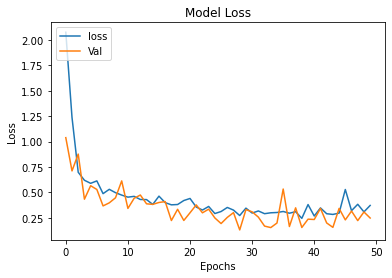

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','Val'], loc = 'upper left')

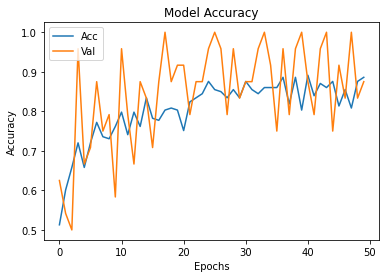

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Acc','Val'], loc = 'upper left')